# Generating subglacial topography with GSatSim

This notebook follows the sequential gaussian simulation (SGS) to generate subglacial topography using the [notebook](https://gatorglaciology.github.io/gstatsimbook/4_Sequential_Gaussian_Simulation.html) on the GStatSim website.

### Idea
We randomly and sparsely sample a given topograph and use the SGS  to fill out areas that were not sampled. By doing this multiple times, the topology generated will be slightly different each time assuming we do not sample "too much".

Import required libraries

In [1]:
import numpy as np
from numpy.random import default_rng
import random
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LightSource
from matplotlib import ticker
from sklearn.preprocessing import QuantileTransformer
import skgstat as skg
from skgstat import models
import gstatsim as gs
import random
import concurrent.futures

Load the dataset prepared by Andrew which has been scaled and organized into 1564 square sections.

In [3]:
data = np.load('data/thw_image_stack.npy')

In [4]:
data.shape

(1564, 512, 512, 1)

Assume that all points are equidistant from each other. This is just a way to create x y indices.

In [5]:
# get row, column indices of a 2D array
def coords(row, col):
    return np.array(list(np.ndindex((row, col)))).reshape(row, col, 2)

Randomly select one of the 1564 sections.

In [6]:
topology_number = random.randint(0,data.shape[0]-1) #Random 0 to 1563
topology = data[topology_number,:,:,0]

Reshape and get into a input (first 2 columns) and output format (last/3rd column)

In [7]:
xy = coords(topology.shape[0], topology.shape[1])
output = topology.reshape(-1,1)
input = xy.reshape(-1, 2)
df_bed_full = pd.DataFrame()
df_bed_full['X'] = input[:,0]
df_bed_full['Y'] = input[:,1]
df_bed_full['Bed'] = output

In [8]:
df_bed_full

,X,Y,Bed
0,0,0,0.381890
1,0,1,0.389764
2,0,2,0.389764
3,0,3,0.389764
4,0,4,0.397638
...,...,...,...
262139,511,507,0.775591
262140,511,508,0.775591
262141,511,509,0.779528
262142,511,510,0.779528


Scater plot for the randomly sampled data

In [9]:
# plot data
def plot_random_data(df_bed, ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(5, 5))

    im = ax.scatter(df_bed['X'], df_bed['Y'], c=df_bed['Bed'],
                    marker='.', s=50, cmap='gist_earth')
    ax.set_title('Subglacial topography data')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.locator_params(nbins=5)
    ax.axis('scaled')

    # make colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Bed elevation (normalized", rotation=270, labelpad=15)

    if ax is None:
        plt.show()

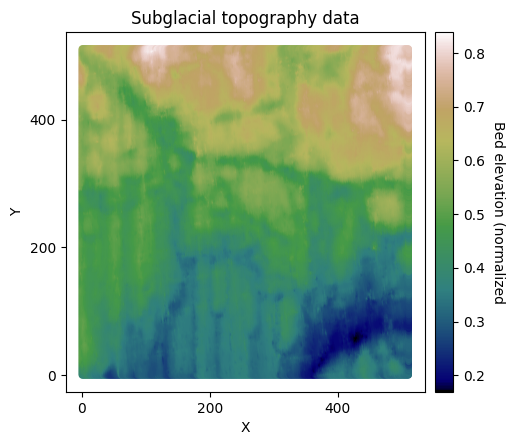

In [10]:
plot_random_data(df_bed_full)

Function to create a variogram given bed data

In [11]:
def return_variogram(df_bed, res = 5):
  df_grid, grid_matrix, rows, cols = gs.Gridding.grid_data(df_bed, 'X', 'Y', 'Bed', res)
  df_grid = df_grid[df_grid["Z"].isnull() == False]
  df_grid = df_grid.rename(columns = {"Z": "Bed"})

  # normal score transformation
  data = df_grid['Bed'].values.reshape(-1,1)
  nst_trans = QuantileTransformer(n_quantiles=500, output_distribution="normal").fit(data)
  df_grid['Nbed'] = nst_trans.transform(data)

  # compute experimental (isotropic) variogram
  coords = df_grid[['X','Y']].values
  values = df_grid['Nbed']

  maxlag = 500             # maximum range distance
  n_lags = 70                # num of bins

  V1 = skg.Variogram(coords, values, bin_func='even', n_lags=n_lags,
                    maxlag=maxlag, normalize=False)

  # use exponential variogram model
  V1.model = 'exponential'
  return V1, df_grid, nst_trans, rows, cols

Create Variogram for the full bed.

In [12]:
V1_full, df_grid_full, nst_trans_full, rows_full, cols_full = return_variogram(df_bed=df_bed_full, res = 10)

Functions to create variogram for a downsampled bed

In [13]:
def create_downsampled_variogram(df_bed_full, samples = 200, res = 5):
  df_bed = df_bed_full.sample(n=samples, axis='rows')
  V1, df_grid, nst_trans, rows, cols = return_variogram(df_bed, res)
  xmin = np.min(df_grid['X']); xmax = np.max(df_grid['X'])     # min and max x values
  ymin = np.min(df_grid['Y']); ymax = np.max(df_grid['Y'])     # min and max y values

  Pred_grid_xy = gs.Gridding.prediction_grid(xmin, xmax, ymin, ymax, res)
  # set variogram parameters
  azimuth = 0
  nugget = V1.parameters[2]

  # the major and minor ranges are the same in this example because it is isotropic
  major_range = V1.parameters[0]
  minor_range = V1.parameters[0]
  sill = V1.parameters[1]
  vtype = 'Exponential'

  # save variogram parameters as a list
  vario = [azimuth, nugget, major_range, minor_range, sill, vtype]

  k = 48         # number of neighboring data points used to estimate a given point
  rad = 50000    # 50 km search radius

  sim = gs.Interpolation.okrige_sgs(Pred_grid_xy, df_grid, 'X', 'Y', 'Nbed', k, vario, rad)

  # reverse normal score transformation
  sim1 = sim.reshape(-1,1)
  sim_trans = nst_trans.inverse_transform(sim1)

  # compute SGS variogram

  # downsample random indices to speed this up
  rand_indices = random.sample(range(np.shape(Pred_grid_xy)[0]),140)

  # get coordinates and normalized simulation from random indices
  coords_s = Pred_grid_xy[rand_indices]
  values_s = sim[rand_indices]

  maxlag = 500             # maximum range distance
  n_lags = 70                # num of bins\

  VS = skg.Variogram(coords_s, values_s, bin_func = "even", n_lags = n_lags,
                    maxlag = maxlag, normalize=False)

  return df_bed, sim_trans, sim, Pred_grid_xy, V1, VS, rows, cols

In [14]:
def plot_sgs_realization(Pred_grid_xy, rows, cols, sim_trans, ax=None):
    # make hillshade for visualizing
    x_mat = Pred_grid_xy[:, 0].reshape((rows, cols))
    y_mat = Pred_grid_xy[:, 1].reshape((rows, cols))
    mat = sim_trans.reshape((rows, cols))
    xmin, xmax = Pred_grid_xy[:, 0].min(), Pred_grid_xy[:, 0].max()
    ymin, ymax = Pred_grid_xy[:, 1].min(), Pred_grid_xy[:, 1].max()

    cmap = plt.get_cmap('gist_earth')

    if ax is None:
        fig, ax = plt.subplots(1, figsize=(5, 5))
    else:
        # Clear the existing plot in the specified axes
        ax.clear()

    im = ax.pcolormesh(x_mat, y_mat, mat, cmap=cmap)

    # Shade from the northeast, with the sun 45 degrees from horizontal
    ls = LightSource(azdeg=45, altdeg=45)

    # leaving the dx and dy as 1 means vertical exaggeration equal to dx/dy
    hillshade = ls.hillshade(mat, vert_exag=1, dx=1, dy=1, fraction=1.0)
    ax.pcolormesh(x_mat, y_mat, hillshade, cmap='gray', alpha=0.1)
    ax.set_title('SGS Realization')
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xticks(np.linspace(xmin, xmax, 5))
    ax.set_yticks(np.linspace(ymin, ymax, 5))

    # make colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='5%', pad=0.1)
    cbar = plt.colorbar(im, cax=cax)
    cbar.set_label("Bed elevation (normalized)", rotation=270, labelpad=15)
    ax.axis('scaled')

    if ax is None:
        plt.show()

Plotting function

In [15]:
def plot_variogram(V1_full, VS, ax=None):
    # experimental variogram (from beginning of script)
    xe = V1_full.bins
    ye = V1_full.experimental

    # simple kriging variogram
    xs = VS.bins
    ys = VS.experimental

    if ax is None:
        plt.figure(figsize=(6, 4))
        ax = plt.gca()
    else:
        # Clear the existing plot in the specified axes
        ax.clear()

    ax.plot(xe, ye, 'og', markersize=4, label='Bed data variogram')
    ax.plot(xs, ys, 'ok', markersize=4, label='SGS variogram')
    ax.set_title('Variogram comparison')
    ax.set_xlabel('Lag')
    ax.set_ylabel('Semivariance')
    ax.legend(loc='upper left')

    if ax is None:
        plt.show()

Functions to generate multiple bed topographs by randomly sampling the same bed.

In [16]:
def generate_sample(i, df_bed_full, V1_full, number_of_random_points=100, res=10):
    df_bed, sim_trans, sim, Pred_grid_xy, V1, VS, rows, cols = create_downsampled_variogram(df_bed_full, samples=number_of_random_points, res=res)

    try:
        fig, axs = plt.subplots(1, 3, figsize=(15, 5))

        # Plot random data
        axs[0].set_title(f"Sample {i+1}")
        plot_random_data(df_bed, ax=axs[0])

        # Plot realization
        plot_sgs_realization(Pred_grid_xy, rows, cols, sim_trans, ax=axs[1])

        # Plot variogram
        plot_variogram(V1_full, VS, ax=axs[2])

        plt.tight_layout()
        plt.show()

    except Exception:
        pass

In [17]:
def generate_multiple_samples_parallel(number_of_samples, df_bed_full, V1_full, number_of_random_points=100, res=10):
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = [executor.submit(generate_sample, i, df_bed_full, V1_full, number_of_random_points, res) for i in range(number_of_samples)]

        # Wait for all futures to complete
        concurrent.futures.wait(futures)

Generate sample by chosing `number_of_random_points` which is the number of random samples of the training bed which was selected randomly in the beginning from a set of available beds. The `res` parameter controls the resolution of the generated bed. `number_of_samples` controls the number of new beds that are created. 

Plot SGS realizations for different values of input

C:\Users\LDEO\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (500) is greater than the total number of samples (98). n_quantiles is set to n_samples.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████| 10098/10098 [01:11<00:00, 141.14it/s]


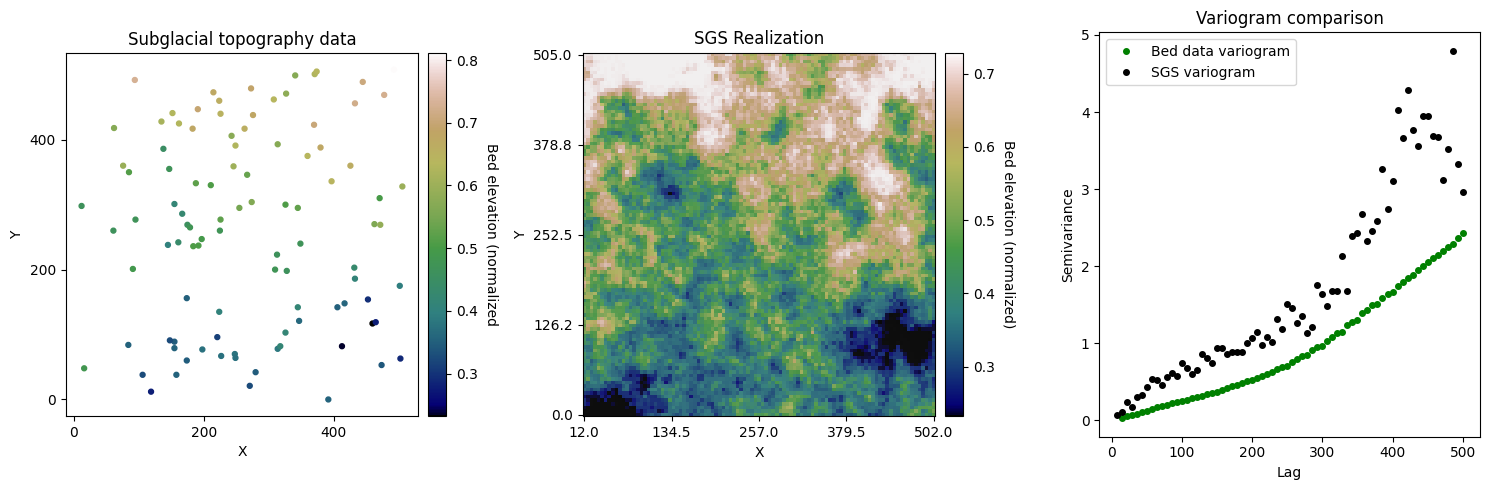

In [20]:
generate_multiple_samples_parallel(number_of_samples=1, df_bed_full=df_bed_full, V1_full=V1_full, number_of_random_points=100, res=5)

C:\Users\LDEO\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (500) is greater than the total number of samples (195). n_quantiles is set to n_samples.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████| 10403/10403 [01:21<00:00, 128.26it/s]


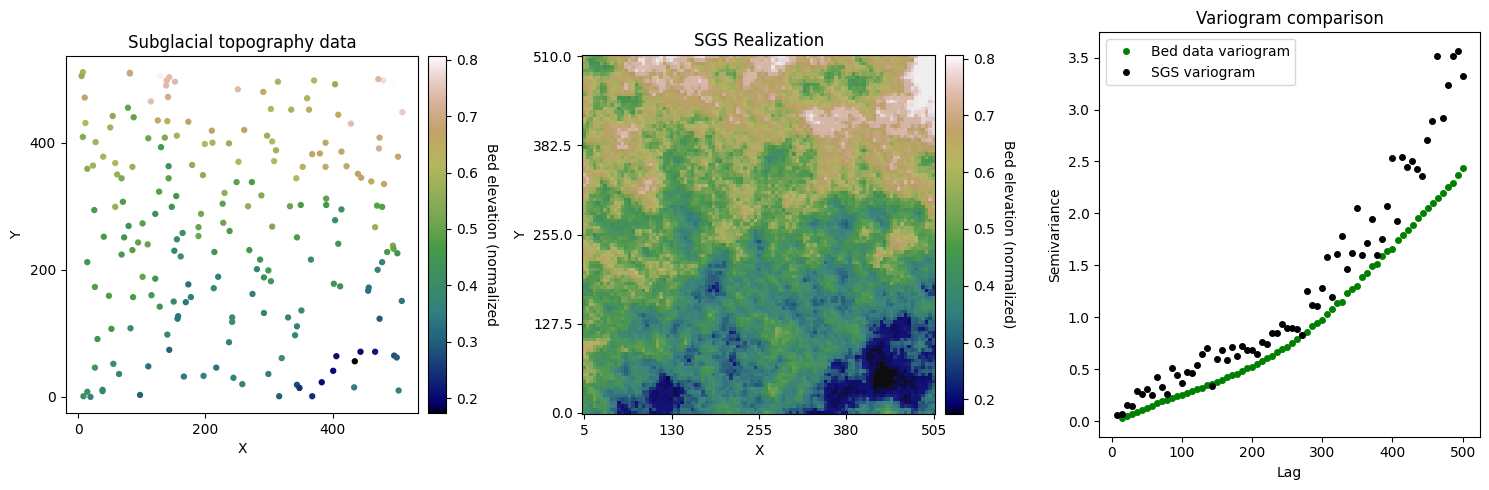

In [23]:
generate_multiple_samples_parallel(number_of_samples=1, df_bed_full=df_bed_full, V1_full=V1_full, number_of_random_points=200, res=5)

C:\Users\LDEO\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (500) is greater than the total number of samples (199). n_quantiles is set to n_samples.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████| 10506/10506 [01:13<00:00, 143.55it/s]


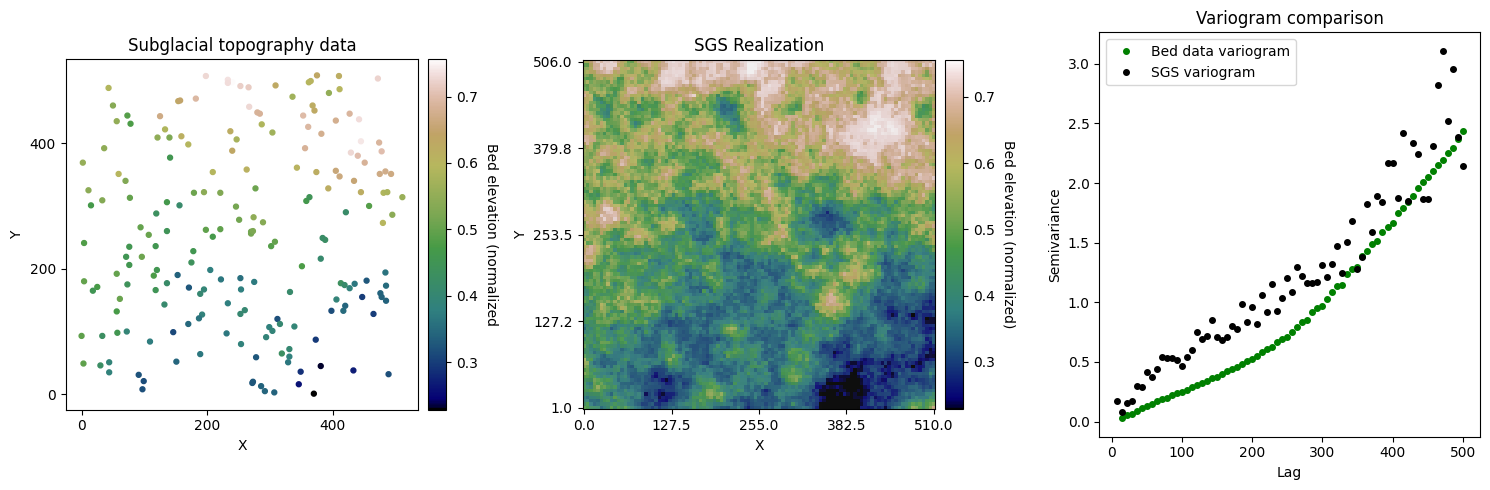

In [26]:
generate_multiple_samples_parallel(number_of_samples=1, df_bed_full=df_bed_full, V1_full=V1_full, number_of_random_points=200, res=5)

C:\Users\LDEO\miniconda3\envs\tf\lib\site-packages\sklearn\preprocessing\_data.py:2663: UserWarning: n_quantiles (500) is greater than the total number of samples (98). n_quantiles is set to n_samples.
  warnings.warn(
100%|█████████████████████████████████████████████████████████████████████| 27720/27720 [04:34<00:00, 100.82it/s]


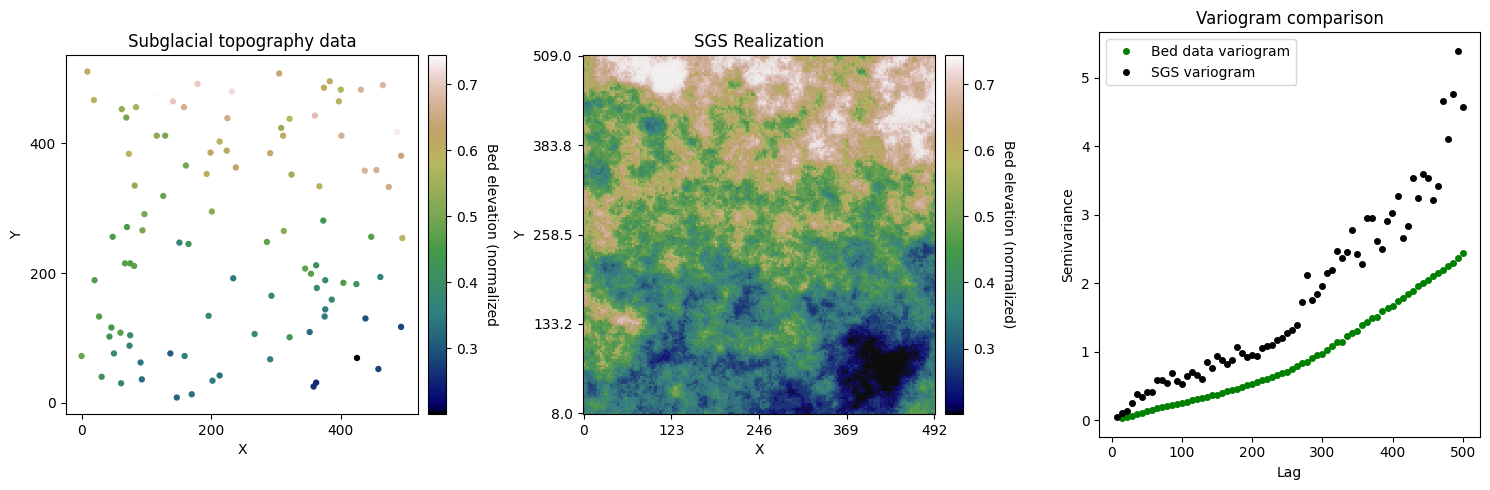

In [25]:
generate_multiple_samples_parallel(number_of_samples=1, df_bed_full=df_bed_full, V1_full=V1_full, number_of_random_points=100, res=3)

The variogram from the generated topograph matches with the original dataset closely for the most part. The realization is similar to the training data which is to be expected. The training time is a strong function of the resolution `res`. Higher the resolution, the more time it takes to generate the topography. Here, with 200 samples and `res` equal to 5 takes about 1 minute with `acceptable` variograms. The accuracy of the variogram for the generated topography is a function of the random points that were sampled. Increasing the number of points results in a variogram closer to the original bed. However this also means we reduce the variation in the generated topograph, which is expected.   